# USAD

## Environment

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn

from utils import *
from usad import *

In [2]:
!nvidia-smi -L

device = get_default_device()

GPU 0: NVIDIA GeForce GTX 1650 (UUID: GPU-d6079c82-a3ed-1a9d-41f1-cfa122659d29)


## EDA - Data Pre-Processing

### Download dataset

### Normal period

In [3]:
#Read data
normal = pd.read_csv("input/SWaT_Dataset_Normal_v1.csv")#, nrows=1000)
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape

/home/pk/miniconda3/envs/usad/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(495000, 51)

In [4]:
# Transform all columns into float64
for i in list(normal): 
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

In [5]:
from sklearn import preprocessing
min_max_scaler = preprocessing.StandardScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [6]:
#Read data
normal = pd.read_csv("input/SWaT_Dataset_Normal_v1.csv")#, nrows=1000)
normal = normal.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
normal.shape

/home/pk/miniconda3/envs/usad/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (26) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(495000, 51)

In [7]:
# Transform all columns into float64
for i in list(normal): 
    normal[i]=normal[i].apply(lambda x: str(x).replace("," , "."))
normal = normal.astype(float)

#### Normalization

In [8]:
from sklearn import preprocessing
min_max_scaler = preprocessing.StandardScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [9]:
normal.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,-1.633984,-3.807291,-1.574619,-1.728131,0.0,-2.477683,-0.828035,-0.719672,-1.731442,-1.684036,...,-17.644775,-17.91219,0.0,-17.843131,-5.7965,-17.672513,-0.095148,0.0,-0.089482,0.0
1,-1.633984,-3.806646,-1.574619,-1.728131,0.0,-2.477683,-0.828035,-0.719672,-1.731442,-1.684036,...,-17.644775,-17.91219,0.0,-17.843131,-5.7965,-17.672513,-0.095148,0.0,-0.089482,0.0


### Attack

In [10]:
#Read data
attack = pd.read_csv("input/SWaT_Dataset_Attack_v0.csv",sep=";")#, nrows=1000)
labels = [ float(label!= 'Normal' ) for label  in attack["Normal/Attack"].values]
attack = attack.drop(["Timestamp" , "Normal/Attack" ] , axis = 1)
attack.shape

/home/pk/miniconda3/envs/usad/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (1,9,28,46) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(449919, 51)

In [11]:
# Transform all columns into float64
for i in list(attack):
    attack[i]=attack[i].apply(lambda x: str(x).replace("," , "."))
attack = attack.astype(float)

#### Normalization

In [12]:
from sklearn import preprocessing

x = attack.values 
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

In [13]:
attack.head(2)

,0,1,2,3,4,5,6,7,8,9,...,41,42,43,44,45,46,47,48,49,50
0,0.509078,-0.531668,0.610641,0.57866,0.0,-0.369209,0.09171,-0.399305,0.577082,0.571882,...,0.030545,0.055828,0.0,-0.067305,2.260671,-0.125269,-0.096008,0.0,-0.089482,0.0
1,0.526046,-0.531345,0.610641,0.57866,0.0,-0.369209,0.09171,-0.399305,0.577082,0.571882,...,0.030545,0.055828,0.0,-0.067305,2.260671,-0.117722,-0.096008,0.0,-0.089482,0.0


### Windows

In [14]:
window_size=20

In [15]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(494980, 20, 51)

In [16]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(449899, 20, 51)

## Training

In [17]:
import torch.utils.data as data_utils

BATCH_SIZE =  1000
N_EPOCHS = 40
hidden_size = 20

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size= windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [18]:
w_size, z_size

(1020, 400)

In [19]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.3759, val_loss2: 0.3749
Epoch [1], val_loss1: 0.4323, val_loss2: -0.0578
Epoch [2], val_loss1: 0.4532, val_loss2: -0.1980
Epoch [3], val_loss1: 0.5117, val_loss2: -0.3190
Epoch [4], val_loss1: 0.4858, val_loss2: -0.3309
Epoch [5], val_loss1: 0.5315, val_loss2: -0.4005
Epoch [6], val_loss1: 0.5415, val_loss2: -0.4340
Epoch [7], val_loss1: 0.5463, val_loss2: -0.4527
Epoch [8], val_loss1: 0.5501, val_loss2: -0.4669
Epoch [9], val_loss1: 0.5528, val_loss2: -0.4762
Epoch [10], val_loss1: 0.5545, val_loss2: -0.4850
Epoch [11], val_loss1: 0.5570, val_loss2: -0.4944
Epoch [12], val_loss1: 0.5587, val_loss2: -0.5002
Epoch [13], val_loss1: 0.5621, val_loss2: -0.5025
Epoch [14], val_loss1: 0.5626, val_loss2: -0.5071
Epoch [15], val_loss1: 0.5631, val_loss2: -0.5114
Epoch [16], val_loss1: 0.5614, val_loss2: -0.5175
Epoch [17], val_loss1: 0.5623, val_loss2: -0.5203
Epoch [18], val_loss1: 0.4953, val_loss2: -0.4536
Epoch [19], val_loss1: 0.5405, val_loss2: -0.5025
Epoch [20],

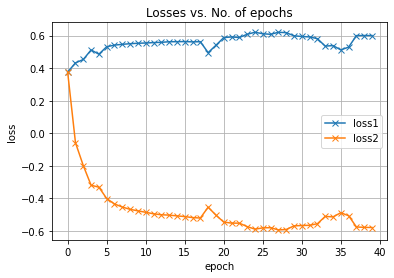

In [21]:
plot_history(history)

In [22]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

In [23]:
model

UsadModel(
  (encoder): Encoder(
    (linear1): Linear(in_features=1020, out_features=510, bias=True)
    (linear2): Linear(in_features=510, out_features=255, bias=True)
    (linear3): Linear(in_features=255, out_features=400, bias=True)
    (relu): ReLU(inplace=True)
  )
  (decoder1): Decoder(
    (linear1): Linear(in_features=400, out_features=255, bias=True)
    (linear2): Linear(in_features=255, out_features=510, bias=True)
    (linear3): Linear(in_features=510, out_features=1020, bias=True)
    (relu): ReLU(inplace=True)
    (sigmoid): Sigmoid()
  )
  (decoder2): Decoder(
    (linear1): Linear(in_features=400, out_features=255, bias=True)
    (linear2): Linear(in_features=255, out_features=510, bias=True)
    (linear3): Linear(in_features=510, out_features=1020, bias=True)
    (relu): ReLU(inplace=True)
    (sigmoid): Sigmoid()
  )
)

## Testing

In [24]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [25]:
results=testing(model,test_loader,0.5,0.5)

In [26]:
len(results)

450

In [27]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))

In [28]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

In [29]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

In [30]:
len(y_test), len(y_pred)

(449899, 449899)

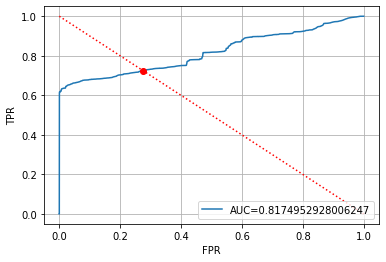

In [31]:
threshold=ROC(y_test,y_pred)

In [32]:
y_pred_ = np.zeros(y_pred.shape[0])

In [33]:
y_pred_[y_pred >= threshold] = 1

In [34]:
y_pred_

array([0., 0., 0., ..., 1., 1., 1.])

In [35]:
np.array(y_test)

array([0., 0., 0., ..., 0., 0., 0.])

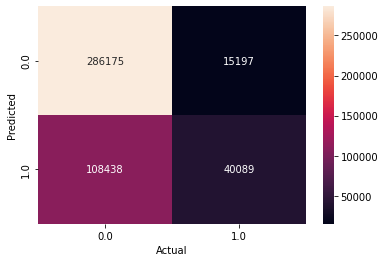

In [36]:
confusion_matrix(np.array(y_test), y_pred_)

In [37]:
import sklearn

In [38]:
print(sklearn.metrics.classification_report(y_test, y_pred_))

              precision    recall  f1-score   support

         0.0       0.95      0.73      0.82    394613
         1.0       0.27      0.73      0.39     55286

    accuracy                           0.73    449899
   macro avg       0.61      0.73      0.61    449899
weighted avg       0.87      0.73      0.77    449899



In [39]:
threshold = 10
y_pred_ = np.zeros(y_pred.shape[0])
y_pred_[y_pred >= threshold] = 1

In [41]:
print(sklearn.metrics.classification_report(y_test, y_pred_))

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97    394613
         1.0       0.90      0.63      0.74     55286

    accuracy                           0.95    449899
   macro avg       0.92      0.81      0.86    449899
weighted avg       0.94      0.95      0.94    449899

